## sraping

In [7]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [2]:
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))
url_list[:5]
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}


from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df


data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

뉴스 기사의 개수:  40


,news,code
0,고려은단이 5월을 맞아 응원 메시지를 공유하는 ‘5월 5글자로 응원 부탁해!’ 이벤...,경제
1,코리아나화장품의 민감성 피부를 위한 저자극 스킨케어 브랜드 '프리엔제'가 마르고 건...,경제
2,서울장수주식회사가 부드럽고 달콤한 맛으로 인기를 모으고 있는 생막걸리 ‘인생막걸리’...,경제
3,[서울=뉴시스] 오동현 기자 = 모바일 게임 기업 컴투스는 3D 모바일 야구 게임 ...,경제
4,대원제약이 2020년 상반기 신입과 경력 정기 공채를 실시합니다.정기 공채 모집분야...,경제
5,"[AFP=연합뉴스] [AFP=연합뉴스]\n\n""요즘은 잔인한 날""…리프트도 앞서 9...",경제
6,이재용 삼성전자 부회장이 6일 삼성전자 서울 서초사옥에서 대국민 사과 회견을 하기 ...,경제
7,JW중외제약이 A형 혈우병 예방요법제 ‘헴리브라피하주사를 출시하고 본격적인 마케팅 ...,경제
8,"옵티팜과 휴벳바이오가 공동 개발중인 백신 후보 물질에 대해 마우스, 기니피그, 미니...",경제
9,[한국경제TV 신동호 기자]\n\n전남 나주시와 충북 청주시가 방사광 가속기 구축사...,경제


In [3]:
code_list = [102, 103, 105]

code_list

def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

df = make_total_data(1, code_list, 20200506)


print('뉴스 기사의 개수: ',len(df))

102번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.
뉴스 기사의 개수:  60


In [26]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/home/aiffel0042/aiffel/news_crawler/news_data.csv File Saved!


In [32]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()


# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거합니다.
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']


print(df.isnull().sum())

# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))


# 중복 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))






news    0
code    0
dtype: int64
뉴스 기사의 개수:  3994
뉴스 기사의 개수:  3994


    code  count
0  IT/과학    903
1     사회   1668
2  생활/문화   1423
['공부', '를', '하', '면', '하', 'ㄹ수록', '모르', '는', '것', '이', '많', '다는', '것', '을', '알', '게', '되', 'ㅂ니다', '.']


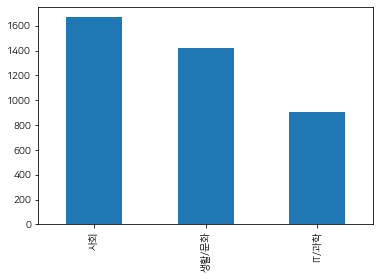

In [57]:
# import matplotlib
# print(matplotlib.__file__)

import matplotlib as plt
from matplotlib import rc
from matplotlib import font_manager as fm
# rc('font', family="Nanum")
font_location='/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
plt.rc('font',family=font_name)
df['code'].value_counts().plot(kind = 'bar')
df['code'].value_counts().plot(kind = 'bar')


print(df.groupby('code').size().reset_index(name = 'count'))


# from konlpy.tag import Mecab
# tokenizer = Mecab()
# from konlpy.tag import Mecab
# tokenizer = Mecab()

from konlpy.tag import Kkma
tokenizer = Kkma()
print(kkma.morphs(u'공부를 하면할수록 모르는게 많다는 것을 알게 됩니다.'))
['공부', '를', '하', '면', '하', 'ㄹ수록', '모르', '는', '것', '이', '많', '다는', '것', '을', '알', '게', '되', 'ㅂ니다', '.']

# stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']



# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data


In [58]:

text_data = preprocessing(df['news'])
print(text_data[0])

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

파주 시청 사진제 공파 주시 파주 시청 사진 제공 파주시 파주 강근주 파 주 시 일 관내 취약 계층 만 가구 대해 정부 긴급 재난 지원금 입금 완료 다파 주 시민 받 긴급 재난 지원금 인 이상 가구 기준 으로 만 원 받 게 되 며 인 가구 만 원 인 가구 만 원 인 가구 만 원 정부 발표 긴급 재난 지원금 파주 시민 지급 금액 다른 이유 국비 지방비 부담 비율 다파 주 시 이미 모든 시민 경기도 파주시 재난 기본 소득 인 당 각 만 원 지급 고 어 시민 국비 지원금 만 지급 며 인 가구 기준 으로 총 지원 금액 파주시 재난 기본소득 만 원 경기도 재난 기본소득 만 원 정부 긴급 재난 지원금 만 원 총 만 원 받 게 된다 취약 계층 아닌 시민 오 월일 부터 소지 고 신용 체크카드 사 홈페이지 에서 긴급 재난 지원금 지원 신청 세대주 가족 지원금 일괄 신청 해야 한다 한편 파 주 시 일 김정기 부시장 단장 으로 긴급 재난 지원금 추진 태 스 크 포스 를 구성 해 긴급 재난 지원금 원활 게 지급 될 도록 지원 한다 권 자 재 배포
훈련용 뉴스 기사의 개수 : 2995
테스트용 뉴스 기사의 개수 :  999
훈련용 레이블의 개수 :  2995
테스트용 레이블의 개수 :  999


In [59]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
print(count_vect)


CountVectorizer()


In [47]:
X_train_counts = count_vect.fit_transform(X_train)
print(X_train_counts)


  (0, 14610)	7
  (0, 2819)	6
  (0, 14634)	7
  (0, 27874)	3
  (0, 18986)	1
  (0, 10446)	1
  (0, 27338)	2
  (0, 31100)	2
  (0, 873)	2
  (0, 19074)	2
  (0, 21234)	1
  (0, 3692)	3
  (0, 1565)	2
  (0, 19730)	3
  (0, 30753)	2
  (0, 17406)	2
  (0, 19785)	3
  (0, 19049)	3
  (0, 14329)	2
  (0, 31118)	6
  (0, 25237)	3
  (0, 8172)	1
  (0, 17904)	1
  (0, 18104)	1
  (0, 12793)	1
  :	:
  (2994, 21612)	1
  (2994, 2498)	1
  (2994, 15327)	1
  (2994, 30172)	1
  (2994, 30203)	1
  (2994, 14558)	1
  (2994, 14633)	1
  (2994, 30213)	1
  (2994, 29298)	2
  (2994, 11008)	3
  (2994, 9709)	1
  (2994, 31415)	1
  (2994, 4166)	3
  (2994, 16383)	1
  (2994, 22759)	1
  (2994, 14196)	1
  (2994, 7932)	1
  (2994, 793)	1
  (2994, 20572)	1
  (2994, 1193)	1
  (2994, 24396)	1
  (2994, 14688)	1
  (2994, 2837)	1
  (2994, 31802)	1
  (2994, 1982)	1


In [38]:
#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf)





  (0, 31486)	0.03468180036355295
  (0, 31328)	0.08714522903990012
  (0, 31309)	0.04267741704275759
  (0, 31287)	0.07751681932977367
  (0, 31118)	0.32427563843454227
  (0, 31100)	0.0906461632681794
  (0, 31087)	0.045519057635256356
  (0, 30753)	0.0741661600851317
  (0, 30729)	0.048601382583305805
  (0, 30680)	0.05600218354629716
  (0, 30391)	0.03199622013388081
  (0, 29986)	0.03010740416081057
  (0, 29755)	0.1483323201702634
  (0, 29725)	0.10809187947818076
  (0, 29245)	0.07027122081409805
  (0, 29058)	0.0370389350897818
  (0, 28843)	0.03690760463609086
  (0, 28677)	0.042266813397783626
  (0, 28013)	0.072610749472719
  (0, 27905)	0.06674350766366433
  (0, 27874)	0.05991860202166898
  (0, 27339)	0.06602015805694865
  (0, 27338)	0.13854389947183726
  (0, 27260)	0.056841384174829646
  (0, 27246)	0.05947626788007378
  :	:
  (2994, 3082)	0.032092206671787235
  (2994, 2837)	0.05413434612301552
  (2994, 2749)	0.029128440566822792
  (2994, 2635)	0.042079503112541106
  (2994, 2570)	0.03795043864

In [39]:
#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [48]:
y_train

2380    생활/문화
23         사회
1042       사회
791        사회
3881    IT/과학
        ...  
1013       사회
4036    IT/과학
1980       사회
3172    생활/문화
3311    생활/문화
Name: code, Length: 2995, dtype: object

In [51]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
#   print(data_counts)
  data_tfidf = tfidf_transformer.transform(data_counts)
#   print(data_tfidf)
  return data_tfidf

In [53]:

new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
#print(tfidf_vectorizer(new_sent))
print(clf.predict(tfidf_vectorizer(new_sent)))



['사회']


In [54]:

new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))



['생활/문화']


In [55]:

new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))





['IT/과학']


In [56]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.90      0.74      0.81       236
          사회       0.79      0.91      0.85       422
       생활/문화       0.81      0.76      0.79       341

    accuracy                           0.82       999
   macro avg       0.83      0.80      0.81       999
weighted avg       0.82      0.82      0.82       999

